In [1]:
# load libraries
import pandas as pd
import numpy as np

np.random.seed(1337) # LDiA relies on a random number generator; this keeps things constant

import matplotlib.pyplot as plt

%matplotlib inline

import nltk
from nltk.tokenize.casual import casual_tokenize            # tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer  # put it back together

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
# the goal of this exercise is to create a model with the highest interpretability without sacrificing too much accuracy.
# so use alphanumeric and punctuation only for tokens
# clean out as much crap as possible from tokens
# then do trigrams for tfidf, and inspect
# then do ldia for topics, and inspect
# then do classification with lda, and logistic regression for a quick check

# Step 1: Get Data

The goal of this exercise is to create a model with the highest interpretability witout sacrificing too much accuracy.
So, I will first load the data and then remove everything that isn't alphanumeric.

In [3]:
src_dir = r'C:\Users\groov\PythonCode\output\trump_tweets\\'
hostile_file = src_dir + 'trump_tweets_hostile_clf.csv'
detokenizer = TreebankWordDetokenizer()

clf_df = pd.read_csv(hostile_file, header=None)
clf_df.columns = ['ts', 'tweet', 'label']
clf_df.drop('ts', axis=1, inplace=True)
clf_df.reset_index(drop=True, inplace=True)

# wrangling
clf_df['tweet'] = clf_df['tweet'].str.replace('&amp;', 'and')

# keep only alphanum
clf_df['tokens'] = clf_df['tweet'].apply(casual_tokenize)
clf_df['tokens'] = clf_df['tokens'].apply(lambda tokens: [token for token in tokens if token.isalnum()])
clf_df['tweet'] = clf_df['tokens'].apply(detokenizer.detokenize)

# extract
word_list = sorted(set(clf_df['tokens'].sum()))

# clean up
clf_df.drop('tokens', axis=1, inplace=True)

clf_df.head()

,tweet,label
0,no matter what you do for the do nothing democ...,1
1,them happy or even a little bit satisfied they...,1
2,the most often used phrase in the lamestream m...,1
3,just like i was right on ventilators our count...,0
4,dems say president trump is trying to open the...,0


Let's also prepare some stopwords that we can experiment with.

In [4]:
from nltk.corpus import stopwords
from spacy.lang.en.stop_words import STOP_WORDS

stop_words = set(stopwords.words('english'))
combined_stop_words = set(list(stop_words) + list(STOP_WORDS))

And let's set aside the data for tfidf and bow.

In [5]:
tweets = clf_df['tweet']
labels = clf_df['label']

# Step 2: Bag of Words

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

counter = CountVectorizer(tokenizer=casual_tokenize, ngram_range=(1,3))

In [7]:
bow_docs = pd.DataFrame(counter.fit_transform(clf_df['tweet'].values).toarray())
column_nums, terms = zip(*sorted(zip(counter.vocabulary_.values(), counter.vocabulary_.keys())))
bow_docs.columns = terms
bow_docs.head()

,0,0 such,0 such talk,0 tim,0 tim ryan,0 witnesses,00,00 a,00 a m,00 p,...,zones,zones we,zones we have,zoom,zucker,zucker will,zucker will be,zuckerberg,zuckerberg recently,zuckerberg recently stated
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# let's look for highest counts by class
bow_df = bow_docs.merge(labels, left_index=True, right_index=True)
bow_df.head()

,0,0 such,0 such talk,0 tim,0 tim ryan,0 witnesses,00,00 a,00 a m,00 p,...,zones we,zones we have,zoom,zucker,zucker will,zucker will be,zuckerberg,zuckerberg recently,zuckerberg recently stated,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
bow_df_agg = bow_df.groupby('label').sum().T

In [35]:
bow_df_agg[1].sort_values(ascending=False)[0:100].index.values

array(['the', 'and', 'to', 'a', 'is', 'of', 'in', 'that', 'i', 'for',
       'it', 'they', 't', 'are', 'on', 'be', 'he', 'do', 'was', 's',
       'have', 'with', 'nothing', 'will', 'democrats', 'this', 'fake',
       'not', 'of the', 'news', 'impeachment', 'no', 'in the', 'just',
       'all', 'you', 'now', 'fake news', 'who', 'so', 'very', 'their',
       'president', 'has', 'do nothing', 'but', 'by', 'people', 'hoax',
       'our', 'as', 'his', 'or', 'me', 'up', 'we', 'even', 'schiff',
       'democrat', 'should', 'she', 'never', 'great', 'would', 'out',
       'what', 'want', 'my', 'pelosi', 'do nothing democrats',
       'nothing democrats', 'don', 'more', 'left', 'don t', 'house',
       'media', 'impeachment hoax', 'to the', 'when', 'like', 'corrupt',
       'him', 'call', 'at', 'the fake', 'nancy', 'from', 'dems', 'which',
       'on the', 'bernie', 'and the', 'radical', 'republican', 'mike',
       'radical left', 'were', 'party', 'if'], dtype=object)

In [36]:
bow_df_agg[0].sort_values(ascending=False)[0:100].index.values

array(['the', 'and', 'to', 'of', 'a', 'in', 'will', 'is', 'for', 'our',
       'great', 'be', 'i', 'on', 'we', 'with', 'that', 'are', 'you', 'it',
       'have', 'will be', 'very', 'has', 'at', 'of the', 'this', 's',
       'they', 'thank', 'by', 'he', 'all', 'thank you', 'in the', 'my',
       'new', 'not', 'as', 'was', 'big', 'people', 'your', 'from',
       'president', 'states', 'but', 'get', 'now', 'been', 'house',
       'for the', 'just', 'and the', 'many', 'country', 'up', 'so',
       'to the', 'more', 'out', 'united', 'm', 'good', 'their', 'today',
       'a great', 'news', 'done', 'white', 'strong', 'who', 'i will',
       'we are', 'p', 'white house', 'do', 'china', 'the united', 'job',
       'republican', 'united states', 't', 'other', 'than',
       'the united states', 'military', 'we will', 'p m', 'an', 'would',
       'there', 'no', 'u', 'deal', 'doing', 'on the', 'if', 'never',
       'with the'], dtype=object)

# Step 2: TF-IDF Vectorize

Next, I'm going to use the cleaned up text and create tf-idf vectors for tokens, bigrams, and trigrams. I'll confirm this still looks good by doing basic tf-idf analysis by label. I am not going to remove stopwords, as they often contain information. For
instance, one common slur is "do nothing democrats", and the word "do" is a stopword. 

In [12]:
tfidf = TfidfVectorizer(tokenizer=casual_tokenize, ngram_range=(1,3), lowercase=True, sublinear_tf=True)

tfidf_docs = tfidf.fit_transform(raw_documents=tweets)

tfidf_docs

<1432x68572 sparse matrix of type '<class 'numpy.float64'>'
	with 137800 stored elements in Compressed Sparse Row format>

In [13]:
tfidf_df = pd.DataFrame(tfidf_docs.todense(), columns=tfidf.vocabulary_)
tfidf_df = tfidf_df.merge(labels, left_index=True, right_index=True)

tfidf_df.head()

,no,matter,what,you,do,for,the,nothing,democrats,how,...,number and it,and it was,it was plenty,was plenty state,plenty state should,state should have,have had them,had them in,them in stockpile,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [14]:
tfidf_df_agg = tfidf_df.groupby('label').mean()
tfidf_df_agg

,no,matter,what,you,do,for,the,nothing,democrats,how,...,that number and,number and it,and it was,it was plenty,was plenty state,plenty state should,state should have,have had them,had them in,them in stockpile
label,,,,,,,,,,,,,,,,,,,,,
0,0.000192,0.00012,0.00012,0.00012,0.00012,0.00000,0.000327,0.000159,0.000159,0.000187,...,0.000118,0.000118,0.000118,0.000136,0.000000,0.000000,0.000000,0.00013,0.00013,0.00013
1,0.000445,0.00000,0.00000,0.00000,0.00000,0.00047,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000253,0.000253,0.000253,0.00000,0.00000,0.00000


In [15]:
tfidf_df_agg.loc[1].sort_values(ascending=False)[0:100].index.values

array(['that advice work', 'and safety of', 'release', 'this difficult',
       '5', 'were perhaps', 'else it is', 'nato spending', 'than 48',
       'can win back', 'its power it', 'd c wolves', 'report or correct',
       'zapotosky', 'the ukraine call', 'permanent',
       'leaking information in', 'keep us', 'many great',
       'witnesses are up', 'the cbs', 'hoax by', 'understands the do',
       'one billion', 'to other', 'of him', 'pelosi will go',
       'see that new', 'with even', 'warren gets out', 'so notified',
       'drug cartels who', 'unfortunately despite', 'trade heading',
       'ninth circuit great', 'editorial worse than',
       'well equipped military', 'her bernie would', 'of how badly',
       'meeting now with', 'baker', 'wonder why', 'champ one of',
       'and is', 'closing our northern', 'and more sinister',
       'h o really', 'quick action', 'to 191 federal',
       'democrats are working', 'themselves in', 'i pay',
       'first prescription drug', 't

In [16]:
tfidf_df_agg.loc[0].sort_values(ascending=False)[0:50].index.values

array(['that advice work', 'release', 'and safety of', 'else it is',
       'her bernie would', '5', 'jail him', 'nato spending',
       'america hates career', 'zapotosky', 'of him',
       'presidential primary', 'this difficult', 'incompetent he made',
       'chance a loser', 'time making the', 's has',
       'crooked hillary fiasco', 'to other', 'd c wolves',
       'warren gets out', 'keep us', 'are smart they', 'very unfair but',
       'were perhaps', 'play the game', 'the publicity he',
       'negative interest low', 'pelosi will go', 'than 48',
       'well equipped military', 'o really', 'up version', 'made up',
       'for some', 'and even', 'administration s', 'who was',
       'meeting now with', 'senator rand', 'something about', 'with even',
       'leaking information in', 'end up being', 'and is', 'one billion',
       'long game', 'wead has written', 'see that new', 'more time doing'],
      dtype=object)

It doesn't seem like tf-idf analysis by label tells us much as an aggregate. I guess it is most useful for search.
But it does provide useful features for topic modeling.

# LDiA Topic Modeling

Next, we're going to use LDiA for topic modeling, as this is a smaller dataset, and LDiA allows for visibility into what
is inside each topic. TruncatedSVD works better on larger datasets, but does not allow for inspection of the topics.

In [17]:
from sklearn.decomposition import LatentDirichletAllocation as LDiA

ldia = LDiA(n_components=100, learning_method='batch', n_jobs=-1, random_state=1337, max_iter=20, verbose=1)
ldia.fit(bow_docs)
#ldia.fit(tfidf_docs)


# try tweaking max_iter and batch_size

iteration: 1 of max_iter: 20
iteration: 2 of max_iter: 20
iteration: 3 of max_iter: 20
iteration: 4 of max_iter: 20
iteration: 5 of max_iter: 20
iteration: 6 of max_iter: 20
iteration: 7 of max_iter: 20
iteration: 8 of max_iter: 20
iteration: 9 of max_iter: 20
iteration: 10 of max_iter: 20
iteration: 11 of max_iter: 20
iteration: 12 of max_iter: 20
iteration: 13 of max_iter: 20
iteration: 14 of max_iter: 20
iteration: 15 of max_iter: 20
iteration: 16 of max_iter: 20
iteration: 17 of max_iter: 20
iteration: 18 of max_iter: 20
iteration: 19 of max_iter: 20
iteration: 20 of max_iter: 20


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=20,
                          mean_change_tol=0.001, n_components=100, n_jobs=-1,
                          perp_tol=0.1, random_state=1337,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=1)

In [18]:
terms = list(counter.vocabulary_.keys())
#terms = list(tfidf.vocabulary_.keys())

In [19]:
import seaborn as sns

components = pd.DataFrame(ldia.components_.T, index=terms)
columns = ["topic_{}".format(col) for col in components.columns]
components.columns = columns
components.head(5)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_90,topic_91,topic_92,topic_93,topic_94,topic_95,topic_96,topic_97,topic_98,topic_99
no,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
matter,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
what,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
you,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
do,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


You can see here that different words are being assigned to different topics. 

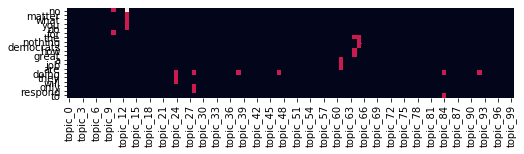

In [20]:
plt.subplots(figsize=(8,8))
_= sns.heatmap(components.head(20), square=True, cbar=False)

Let's inspect the topics to see if we can find any hostile topics. Keep in mind that although the scores seem very similar 
betweet topics. there are subtle differences.

In [21]:
for col in components.columns:
    print(col)
    print()
    output = components[col].sort_values(ascending=False).head(10)
    print(output)
    print()
    print('---------------------------------------------------------')

topic_0

and safety of       11.010000
that advice work     9.636847
release              7.673150
this difficult       6.010000
5                    5.974776
d c wolves           4.869389
were perhaps         3.010000
nato spending        3.010000
her bernie would     3.010000
to other             3.010000
Name: topic_0, dtype: float64

---------------------------------------------------------
topic_1

that advice work        46.624810
ran the country         45.607213
disaster that           43.010000
rate washington         41.478595
chance a loser          40.548089
a mess i                40.010000
city which is           39.831479
incompetent he made     39.742389
america hates career    38.270825
nato spending           38.084239
Name: topic_1, dtype: float64

---------------------------------------------------------
topic_2

that advice work     20.249364
rejected their       15.010000
addressed to my      15.010000
not addressed to     15.010000
5                    10.040741


Name: topic_23, dtype: float64

---------------------------------------------------------
topic_24

that advice work    31.849316
release             18.766160
nato spending       14.065951
else it is          12.971362
this difficult      11.032285
and safety of       10.896697
5                    8.054363
than 48              7.065370
d c wolves           7.010000
her bernie would     6.010000
Name: topic_24, dtype: float64

---------------------------------------------------------
topic_25

that advice work    38.232610
and safety of       22.444536
release             22.147541
else it is          11.303945
5                   10.924202
nato spending        8.010000
keep us              7.930395
permanent            7.010000
this difficult       7.010000
were perhaps         7.010000
Name: topic_25, dtype: float64

---------------------------------------------------------
topic_26

intolerable because the    1.981880
do not exist               1.889036
it away                    1

Name: topic_48, dtype: float64

---------------------------------------------------------
topic_49

and safety of       3.746741
were perhaps        2.010000
pent up demand      2.010000
that advice work    2.010000
end up being        2.010000
the cbs             2.010000
this difficult      2.010000
release             2.010000
else it is          2.010000
every now and       2.010000
Name: topic_49, dtype: float64

---------------------------------------------------------
topic_50

release                   14.789306
that advice work          12.634982
and safety of              7.010000
5                          5.998237
warren gets out            5.972046
else it is                 5.928974
well equipped military     4.987100
to other                   4.964821
of him                     4.010000
margin they                4.010000
Name: topic_50, dtype: float64

---------------------------------------------------------
topic_51

that advice work    26.952508
and safety of       

Name: topic_78, dtype: float64

---------------------------------------------------------
topic_79

that advice work    26.855633
release             19.841169
and safety of       18.870139
zapotosky           14.034836
than 48             11.978390
5                    9.029284
this difficult       8.939689
nato spending        8.932462
d c wolves           8.045340
of him               7.071441
Name: topic_79, dtype: float64

---------------------------------------------------------
topic_80

that advice work    19.800686
and safety of       11.916172
else it is           9.782813
nato spending        6.951396
her bernie would     5.962618
release              5.843545
5                    5.695791
meeting now with     4.987505
of him               4.955600
its power it         4.010000
Name: topic_80, dtype: float64

---------------------------------------------------------
topic_81

that advice work    4.482189
and safety of       4.479264
nato spending       3.800537
release      

So, that's some interesting visibility into the topics. That's one very nice thing about LDiA. So, now, onto prediction.

But first, let's make the topic vectors for use in prediction.

In [22]:
topic_vectors = ldia.transform(bow_docs)
#topic_vectors = ldia.transform(tfidf_docs)

columns = ['topic_{}'.format(i) for i in range(ldia.n_components)]
topic_vectors = pd.DataFrame(topic_vectors, columns=columns)
topic_vectors.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_90,topic_91,topic_92,topic_93,topic_94,topic_95,topic_96,topic_97,topic_98,topic_99
0,0.000060,0.000060,0.000060,0.000060,0.000060,0.000060,0.000060,0.000060,0.000060,0.000060,...,0.000060,0.000060,0.000060,0.000060,0.000060,0.000060,0.000060,0.000060,0.000060,0.000060
1,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,...,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065
2,0.000068,0.000068,0.000068,0.000068,0.000068,0.000068,0.993311,0.000068,0.000068,0.000068,...,0.000068,0.000068,0.000068,0.000068,0.000068,0.000068,0.000068,0.000068,0.000068,0.000068
3,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,...,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072
4,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066,0.151815,...,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066


# Hostile Classification

This part is a work in progress. Get ideas from this guide and possibly re-read the chapter from the book.
https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

In [23]:
X = topic_vectors
y = labels

X.shape, y.shape

((1432, 100), (1432,))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1337, test_size=0.5)
X_train.shape, X_test.shape, len(y_train), len(y_test)

((716, 100), (716, 100), 716, 716)

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=1, solver='lsqr', shrinkage=0.4)
lda.fit(X_train, y_train)
lda.score(X_train, y_train), lda.score(X_test, y_test)

# LatentDirichletAllocation topic modeling

# (0.6731843575418994, 0.5279329608938548) - bow w/o stopwords
# (0.6871508379888268, 0.5572625698324022) - bow w/ all characters w/o stopwords
# (0.6885474860335196, 0.5502793296089385) - bow w/ all characters and all stopwords
# (0.6871508379888268, 0.5502793296089385) - more ldia runs... so doesn't improve. moving on

# (0.6620111731843575, 0.5544692737430168) - tfidf w/o stopwords
# (0.6564245810055865, 0.5614525139664804) - tfidf w/ all characters w/o stopwords
# (0.7262569832402235, 0.6075418994413407) - tfidf w/ all characters and all stopwords

(0.6997206703910615, 0.5879888268156425)

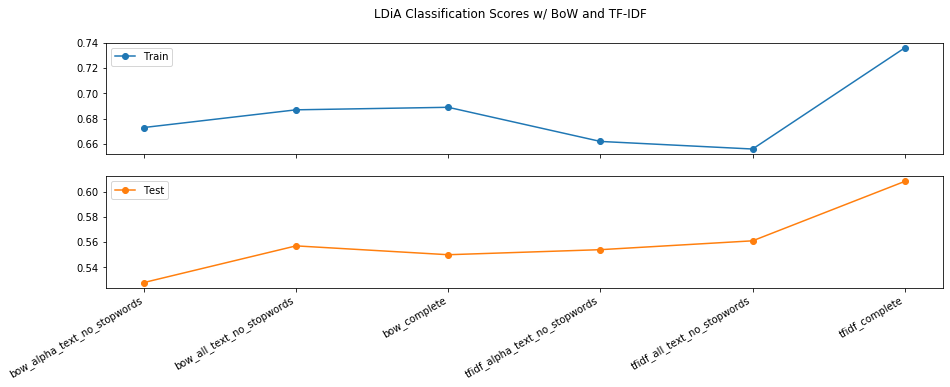

In [26]:
bow_1 = [0.673, 0.528]
bow_2 = [0.687, 0.557]
bow_3 = [0.689, 0.550]

tfidf_1 = [0.662, 0.554]
tfidf_2 = [0.656, 0.561]
tfidf_3 = [0.736, 0.608]

res_df = pd.DataFrame({'1':bow_1, '2':bow_2, '3':bow_3, '4':tfidf_1, '5':tfidf_2, '6':tfidf_3})
res_df.columns = ['bow_alpha_text_no_stopwords', 'bow_all_text_no_stopwords', 'bow_complete',
                 'tfidf_alpha_text_no_stopwords', 'tfidf_all_text_no_stopwords', 'tfidf_complete']
res_df = res_df.T
res_df.columns = ['Train', 'Test']
_= res_df.plot(figsize=(15,5), marker='o', title='LDiA Classification Scores w/ BoW and TF-IDF', subplots=True)

# Topic Modeling with TruncatedSVD

In [27]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, n_iter=100, random_state=1337)
#svd_topic_vectors = svd.fit_transform(bow_docs)
svd_topic_vectors = svd.fit_transform(tfidf_docs)

In [28]:
X = svd_topic_vectors
y = labels

X.shape, y.shape

((1432, 100), (1432,))

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1337, test_size=0.5)
X_train.shape, X_test.shape, len(y_train), len(y_test)

((716, 100), (716, 100), 716, 716)

In [30]:
lda = LDA(n_components=1, solver='lsqr', shrinkage=0.4)
lda.fit(X_train, y_train)
lda.score(X_train, y_train), lda.score(X_test, y_test)

# truncatedSVD topic modeling
# (0.8729050279329609, 0.8337988826815642) - bow w/ all characters and all stopwords
# (0.909217877094972, 0.8980446927374302) - tfidf w/ all characters and all stopwords
# (0.9050279329608939, 0.8784916201117319) - tfidf alphanum and all stopwords - simple and interpretable

(0.9050279329608939, 0.8784916201117319)

In [31]:
topic_df = pd.DataFrame(X).merge(labels, left_index=True, right_index=True)
topic_df_0 = topic_df[topic_df['label']==0].iloc[:,0:100]
topic_df_1 = topic_df[topic_df['label']==1].iloc[:,0:100]

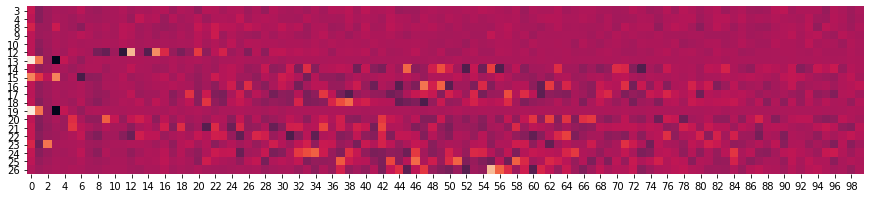

In [32]:
plt.subplots(figsize=(15,5))
_= sns.heatmap(topic_df_0.head(20), cbar=False, square=True)

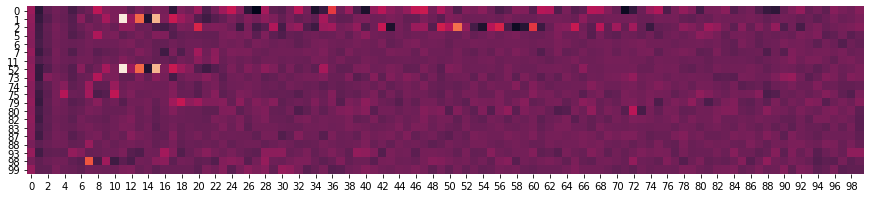

In [33]:
plt.subplots(figsize=(15,5))
_= sns.heatmap(topic_df_1.head(20), cbar=False, square=True)

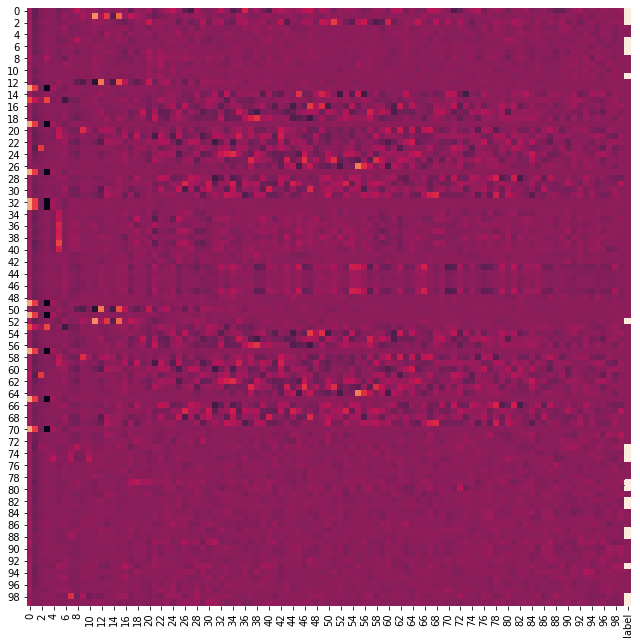

In [34]:
plt.subplots(figsize=(11,11))
_= sns.heatmap(topic_df.head(100), cbar=False, square=True)